In [1]:
#PIP INSTALLATION
print('---1---')
%pip install pandas
print('---2---')
%pip install seaborn
print('---3---')
%pip install scikit-learn
print('---4---')
%pip install catboost
print('---5---')
%pip install ipywidgets
print('---6---')
%pip install pandas openpyxl

---1---
Note: you may need to restart the kernel to use updated packages.
---2---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---3---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---4---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---5---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
---6---



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#FROM LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
from IPython.display import FileLink
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from typing import List, Optional
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)

#IMPORT AS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

In [3]:
file_path = 'Dataset/diabetic_data.csv'
df = pd.read_csv(file_path,keep_default_na=False)
df_clean = df.copy()
df_clean.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


DATA CLEANING

In [4]:
#REMOVING DUPLICATE DATA'S
df_clean['patient_nbr'].value_counts()
df_clean = df_clean.drop_duplicates(subset=['patient_nbr'])

In [5]:
features_drop_list = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'repaglinide', 'nateglinide', 'chlorpropamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone', 'acetohexamide', 'tolbutamide']
df_clean.drop(features_drop_list, axis=1, inplace=True)

In [6]:
#start by setting all values containing E or V into 0 (as one category)
df_clean.loc[df_clean['diag_1'].str.contains('V',na=False,case=False), 'diag_1'] = 0
df_clean.loc[df_clean['diag_1'].str.contains('E',na=False,case=False), 'diag_1'] = 0
df_clean.loc[df_clean['diag_2'].str.contains('V',na=False,case=False), 'diag_2'] = 0
df_clean.loc[df_clean['diag_2'].str.contains('E',na=False,case=False), 'diag_2'] = 0
df_clean.loc[df_clean['diag_3'].str.contains('V',na=False,case=False), 'diag_3'] = 0
df_clean.loc[df_clean['diag_3'].str.contains('E',na=False,case=False), 'diag_3'] = 0

#setting all missing values into -1
df_clean['diag_1'] = df_clean['diag_1'].replace('?', -1)
df_clean['diag_2'] = df_clean['diag_2'].replace('?', -1)
df_clean['diag_3'] = df_clean['diag_3'].replace('?', -1)

#No all diag values can be converted into numeric values
df_clean['diag_1'] = df_clean['diag_1'].astype(float)
df_clean['diag_2'] = df_clean['diag_2'].astype(float)
df_clean['diag_3'] = df_clean['diag_3'].astype(float)

In [7]:
# Ensure 'diag_1', 'diag_2', 'diag_3' are numeric
df_clean[['diag_1', 'diag_2', 'diag_3']] = df_clean[['diag_1', 'diag_2', 'diag_3']].apply(pd.to_numeric, errors='coerce')

def categorize_diag(df_clean, col):
    df_clean.loc[(df_clean[col] >= 1) & (df_clean[col] < 140), col] = 1
    df_clean.loc[(df_clean[col] >= 140) & (df_clean[col] < 240), col] = 2
    df_clean.loc[(df_clean[col] >= 240) & (df_clean[col] < 280), col] = 3
    df_clean.loc[(df_clean[col] >= 280) & (df_clean[col] < 290), col] = 4
    df_clean.loc[(df_clean[col] >= 290) & (df_clean[col] < 320), col] = 5
    df_clean.loc[(df_clean[col] >= 320) & (df_clean[col] < 390), col] = 6
    df_clean.loc[(df_clean[col] >= 390) & (df_clean[col] < 460), col] = 7
    df_clean.loc[(df_clean[col] >= 460) & (df_clean[col] < 520), col] = 8
    df_clean.loc[(df_clean[col] >= 520) & (df_clean[col] < 580), col] = 9
    df_clean.loc[(df_clean[col] >= 580) & (df_clean[col] < 630), col] = 10
    df_clean.loc[(df_clean[col] >= 630) & (df_clean[col] < 680), col] = 11
    df_clean.loc[(df_clean[col] >= 680) & (df_clean[col] < 710), col] = 12
    df_clean.loc[(df_clean[col] >= 710) & (df_clean[col] < 740), col] = 13
    df_clean.loc[(df_clean[col] >= 740) & (df_clean[col] < 760), col] = 14
    df_clean.loc[(df_clean[col] >= 760) & (df_clean[col] < 780), col] = 15
    df_clean.loc[(df_clean[col] >= 780) & (df_clean[col] < 800), col] = 16
    df_clean.loc[(df_clean[col] >= 800) & (df_clean[col] < 1000), col] = 17
    df_clean.loc[df_clean[col] == -1, col] = 0  # Handle missing values
    
# Apply function to diagnosis columns
for col in ['diag_1', 'diag_2', 'diag_3']:
    categorize_diag(df_clean, col)

# Print the result
print(df_clean[['diag_1', 'diag_2', 'diag_3']].head())

   diag_1  diag_2  diag_3
0     3.0     0.0     0.0
1     3.0     3.0     3.0
2    11.0     3.0     0.0
3     1.0     3.0     7.0
4     2.0     2.0     3.0


In [8]:
df_clean.diag_2.unique()

array([ 0.,  3.,  2.,  7.,  8.,  4., 17., 13., 10.,  1.,  9., 12.,  6.,
       16.,  5., 11., 14.])

In [9]:
df_clean['race'] = df_clean['race'].replace('?', 'Other')
df_clean.race.value_counts()

race
Caucasian          53491
AfricanAmerican    12887
Other               3126
Hispanic            1517
Asian                497
Name: count, dtype: int64

In [10]:
df_clean['gender'] = df_clean['gender'].replace('Unknown/Invalid', 'Female')
df_clean.gender.value_counts()

gender
Female    38028
Male      33490
Name: count, dtype: int64

In [11]:
df_clean['gender'] = df_clean['gender'].replace('Male', 1)
df_clean['gender'] = df_clean['gender'].replace('Female', 0)
df_clean.gender.value_counts()

C:\Users\SnowPlay\AppData\Local\Temp\ipykernel_18776\2177177959.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['gender'] = df_clean['gender'].replace('Female', 0)


gender
0    38028
1    33490
Name: count, dtype: int64

In [12]:
age_replacements = {}
for i in range(0, 10):
    age_range = f'[{10*i}-{10*(i+1)})'
    midpoint = i*10 + 5
    age_replacements[age_range] = midpoint

df_clean['age'] = df_clean['age'].replace(age_replacements)

df_clean['age'].value_counts()

C:\Users\SnowPlay\AppData\Local\Temp\ipykernel_18776\856190937.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['age'] = df_clean['age'].replace(age_replacements)


age
75    18210
65    15960
55    12466
85    11589
45     6878
35     2699
95     1900
25     1127
15      535
5       154
Name: count, dtype: int64

In [13]:
df_clean['readmitted']=df_clean['readmitted'].replace('NO', 0)
df_clean['readmitted']=df_clean['readmitted'].replace('>30', 1)
df_clean['readmitted']=df_clean['readmitted'].replace('<30', 2)
df_clean.readmitted.value_counts()

C:\Users\SnowPlay\AppData\Local\Temp\ipykernel_18776\3891844975.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['readmitted']=df_clean['readmitted'].replace('<30', 2)


readmitted
0    42985
1    22240
2     6293
Name: count, dtype: int64

In [14]:
df_clean = pd.concat([df_clean,pd.get_dummies(df_clean['race'], prefix='race')], axis=1).drop(['race'],axis=1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71518 entries, 0 to 101765
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender                    71518 non-null  int64  
 1   age                       71518 non-null  int64  
 2   admission_type_id         71518 non-null  int64  
 3   discharge_disposition_id  71518 non-null  int64  
 4   admission_source_id       71518 non-null  int64  
 5   time_in_hospital          71518 non-null  int64  
 6   num_lab_procedures        71518 non-null  int64  
 7   num_procedures            71518 non-null  int64  
 8   num_medications           71518 non-null  int64  
 9   number_outpatient         71518 non-null  int64  
 10  number_emergency          71518 non-null  int64  
 11  number_inpatient          71518 non-null  int64  
 12  diag_1                    71518 non-null  float64
 13  diag_2                    71518 non-null  float64
 14  diag_3    

In [15]:
race_columns = ['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other']
df_clean[race_columns] = df_clean[race_columns].astype(int)
# Check the changes
print(df_clean[race_columns].head())

   race_AfricanAmerican  race_Asian  race_Caucasian  race_Hispanic  race_Other
0                     0           0               1              0           0
1                     0           0               1              0           0
2                     1           0               0              0           0
3                     0           0               1              0           0
4                     0           0               1              0           0


In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71518 entries, 0 to 101765
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender                    71518 non-null  int64  
 1   age                       71518 non-null  int64  
 2   admission_type_id         71518 non-null  int64  
 3   discharge_disposition_id  71518 non-null  int64  
 4   admission_source_id       71518 non-null  int64  
 5   time_in_hospital          71518 non-null  int64  
 6   num_lab_procedures        71518 non-null  int64  
 7   num_procedures            71518 non-null  int64  
 8   num_medications           71518 non-null  int64  
 9   number_outpatient         71518 non-null  int64  
 10  number_emergency          71518 non-null  int64  
 11  number_inpatient          71518 non-null  int64  
 12  diag_1                    71518 non-null  float64
 13  diag_2                    71518 non-null  float64
 14  diag_3    

In [17]:
X = df_clean.drop('readmitted', axis=1)  # Features
y = df_clean['readmitted']               # Target variable

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = [col for col in X.columns if X[col].dtype == 'object']


In [19]:
class MultiClassCVEvaluator:
    def __init__(
        self,
        models: List,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_test: pd.DataFrame,
        y_test: pd.Series,
        cat_features: List[int]
    ):
        self.models = models
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cat_features = cat_features
        
        # Calculate predictions for each fold's model
        self.fold_predictions = []
        self.fold_probabilities = []
        for model in self.models:
            self.fold_predictions.append(model.predict(X_test))
            self.fold_probabilities.append(model.predict_proba(X_test))
            
    def plot_learning_curves(self, fold_idx: Optional[int] = None, figsize: tuple = (12, 5)):
        """Plot learning curves for a specific fold or all folds."""
        plt.figure(figsize=figsize)
        
        if fold_idx is not None:
            model = self.models[fold_idx]
            train_loss = model.get_evals_result()['learn']['MultiClass']
            if 'validation' in model.get_evals_result():
                val_loss = model.get_evals_result()['validation']['MultiClass']
            
            plt.plot(train_loss, label=f'Training Loss Fold {fold_idx}')
            if 'validation' in model.get_evals_result():
                plt.plot(val_loss, label=f'Validation Loss Fold {fold_idx}')
        else:
            for i, model in enumerate(self.models):
                train_loss = model.get_evals_result()['learn']['MultiClass']
                if 'validation' in model.get_evals_result():
                    val_loss = model.get_evals_result()['validation']['MultiClass']
                
                plt.plot(train_loss, alpha=0.3, color='blue')
                if 'validation' in model.get_evals_result():
                    plt.plot(val_loss, alpha=0.3, color='orange')
            
            plt.plot([], [], color='blue', label='Training Loss (all folds)')
            plt.plot([], [], color='orange', label='Validation Loss (all folds)')
        
        plt.title('Learning Curves')
        plt.xlabel('Iterations')
        plt.ylabel('MultiClass Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_feature_importance(self, top_n: Optional[int] = 20, figsize: tuple = (10, 6)):
        """Plot average feature importance across all folds."""
        importance_matrices = []
        for model in self.models:
            importance = pd.DataFrame({
                'Feature': self.X_train.columns,
                'Importance': model.get_feature_importance()
            })
            importance_matrices.append(importance.set_index('Feature')['Importance'])
        
        mean_importance = pd.concat(importance_matrices, axis=1).mean(axis=1)
        std_importance = pd.concat(importance_matrices, axis=1).std(axis=1)
        
        importance_df = pd.DataFrame({
            'Feature': mean_importance.index,
            'Importance': mean_importance.values,
            'Std': std_importance.values
        }).sort_values('Importance', ascending=False)
        
        if top_n:
            importance_df = importance_df.head(top_n)
        
        plt.figure(figsize=figsize)
        plt.errorbar(
            importance_df['Importance'],
            range(len(importance_df)),
            xerr=importance_df['Std'],
            fmt='o',
            capsize=5
        )
        plt.yticks(range(len(importance_df)), importance_df['Feature'])
        plt.title(f'Top {top_n} Feature Importance (averaged across folds)' if top_n else 'Feature Importance')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrices(self, figsize: tuple = (15, 5)):
        """Plot confusion matrices for all folds and mean."""
        n_folds = len(self.models)
        fig, axes = plt.subplots(1, n_folds + 1, figsize=figsize)
        
        fold_cms = []
        for i, y_pred in enumerate(self.fold_predictions):
            cm = confusion_matrix(self.y_test, y_pred)
            fold_cms.append(cm)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Fold {i+1}')
            axes[i].set_ylabel('True Label')
            axes[i].set_xlabel('Predicted Label')
        
        mean_cm = np.mean(fold_cms, axis=0)
        sns.heatmap(mean_cm, annot=True, fmt='.1f', cmap='Blues', ax=axes[-1])
        axes[-1].set_title('Mean Confusion Matrix')
        axes[-1].set_ylabel('True Label')
        axes[-1].set_xlabel('Predicted Label')
        
        plt.tight_layout()
        plt.show()

    def get_metrics(self) -> dict:
        """Calculate and return mean metrics across all folds."""
        fold_metrics = []
        
        for y_pred, y_pred_proba in zip(self.fold_predictions, self.fold_probabilities):
            metrics = {
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred, average='weighted'),
                'Recall': recall_score(self.y_test, y_pred, average='weighted'),
                'F1 Score': f1_score(self.y_test, y_pred, average='weighted')
            }
            
            # Add multiclass ROC AUC if applicable
            try:
                metrics['ROC AUC'] = roc_auc_score(
                    self.y_test, 
                    y_pred_proba,
                    multi_class='ovr',
                    average='weighted'
                )
            except:
                pass
                
            fold_metrics.append(metrics)
        
        mean_metrics = {}
        std_metrics = {}
        for metric in fold_metrics[0].keys():
            values = [m[metric] for m in fold_metrics]
            mean_metrics[metric] = np.mean(values)
            std_metrics[metric] = np.std(values)
        
        return {
            'fold_metrics': fold_metrics,
            'mean_metrics': mean_metrics,
            'std_metrics': std_metrics
        }

    def print_metrics(self):
        """Print all metrics in a formatted way."""
        metrics = self.get_metrics()
        
        print("\nModel Performance Metrics:")
        print("-------------------------")
        
        for i, fold_metric in enumerate(metrics['fold_metrics']):
            print(f"\nFold {i+1}:")
            for metric, value in fold_metric.items():
                print(f"{metric}: {value:.4f}")
        
        print("\nMean Metrics (± std):")
        for metric in metrics['mean_metrics'].keys():
            mean_value = metrics['mean_metrics'][metric]
            std_value = metrics['std_metrics'][metric]
            print(f"{metric}: {mean_value:.4f} ± {std_value:.4f}")

    def evaluate_all(self):
        """Run all evaluations and plots."""
        self.print_metrics()
        self.plot_learning_curves()
        self.plot_feature_importance()
        self.plot_confusion_matrices()

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store models and their performance
trained_models = []
fold_scores = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    print(f"\nTraining fold {fold}")
    
    # Split data for this fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Create Pool objects with categorical features
    train_pool = Pool(
        data=X_train_fold,
        label=y_train_fold,
        cat_features=cat_features
    )
    
    test_pool = Pool(
        data=X_test_fold,
        label=y_test_fold,
        cat_features=cat_features
    )
    
    # Initialize CatBoost model with multiclass parameters
    model = CatBoostClassifier(
        learning_rate=0.1,
        depth=6,
        iterations=500,
        l2_leaf_reg=3,
        border_count=32,
        bootstrap_type='Bernoulli',
        subsample=0.8,
        loss_function='MultiClass',  # Explicitly set for multiclass
        eval_metric='MultiClass',    # Use multiclass evaluation metric
        classes_count=len(np.unique(y)),  # Specify number of classes
        random_state=42,
        task_type="GPU",
        verbose=100
    )
    
    # Train the model
    model.fit(
        train_pool,
        eval_set=test_pool,
        early_stopping_rounds=50,
        verbose=100,
        plot=True  # Enable training visualization if in notebook
    )
    
    # Make predictions on test fold
    y_pred = model.predict(X_test_fold)
    
    # Calculate and store fold score
    fold_score = model.score(X_test_fold, y_test_fold)
    fold_scores.append(fold_score)
    
    # Store the trained model
    trained_models.append(model)
    
    print(f"Fold {fold} accuracy: {fold_score:.4f}")

# Print overall cross-validation results
print("\nCross-validation results:")
print(f"Mean accuracy: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores) * 2:.4f})")


Training fold 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0553416	test: 1.0551948	best: 1.0551948 (0)	total: 653ms	remaining: 5m 25s
100:	learn: 0.8188685	test: 0.8291383	best: 0.8291383 (100)	total: 1.97s	remaining: 7.76s
200:	learn: 0.8058110	test: 0.8250476	best: 0.8250476 (200)	total: 3.37s	remaining: 5.02s
300:	learn: 0.7960337	test: 0.8234052	best: 0.8233679 (298)	total: 4.92s	remaining: 3.25s
400:	learn: 0.7907433	test: 0.8228571	best: 0.8228571 (400)	total: 6.35s	remaining: 1.57s
499:	learn: 0.7865062	test: 0.8224448	best: 0.8224417 (498)	total: 7.85s	remaining: 0us
bestTest = 0.8224416985
bestIteration = 498
Shrink model to first 499 iterations.
Fold 1 accuracy: 0.6214

Training fold 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0552167	test: 1.0552763	best: 1.0552763 (0)	total: 21.5ms	remaining: 10.7s
100:	learn: 0.8164295	test: 0.8331752	best: 0.8331752 (100)	total: 1.33s	remaining: 5.26s
200:	learn: 0.8029564	test: 0.8295929	best: 0.8295849 (199)	total: 2.62s	remaining: 3.9s
bestTest = 0.8292166691
bestIteration = 216
Shrink model to first 217 iterations.
Fold 2 accuracy: 0.6183

Training fold 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0552235	test: 1.0555382	best: 1.0555382 (0)	total: 15.6ms	remaining: 7.81s
100:	learn: 0.8161635	test: 0.8322671	best: 0.8322671 (100)	total: 1.52s	remaining: 6.02s
200:	learn: 0.8009738	test: 0.8287888	best: 0.8287873 (199)	total: 2.84s	remaining: 4.22s
300:	learn: 0.7929650	test: 0.8279414	best: 0.8279414 (300)	total: 4.13s	remaining: 2.73s
400:	learn: 0.7864228	test: 0.8272081	best: 0.8271882 (397)	total: 5.45s	remaining: 1.35s
499:	learn: 0.7810559	test: 0.8267373	best: 0.8267286 (493)	total: 6.74s	remaining: 0us
bestTest = 0.8267286331
bestIteration = 493
Shrink model to first 494 iterations.
Fold 3 accuracy: 0.6216

Training fold 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0551418	test: 1.0555786	best: 1.0555786 (0)	total: 15.5ms	remaining: 7.74s
100:	learn: 0.8166153	test: 0.8326078	best: 0.8326078 (100)	total: 1.39s	remaining: 5.5s
200:	learn: 0.8031437	test: 0.8287451	best: 0.8286828 (193)	total: 2.75s	remaining: 4.09s
300:	learn: 0.7941069	test: 0.8277767	best: 0.8277350 (292)	total: 4.12s	remaining: 2.72s
400:	learn: 0.7869755	test: 0.8273292	best: 0.8273292 (400)	total: 5.41s	remaining: 1.34s
499:	learn: 0.7811814	test: 0.8273346	best: 0.8271770 (458)	total: 6.67s	remaining: 0us
bestTest = 0.8271769772
bestIteration = 458
Shrink model to first 459 iterations.
Fold 4 accuracy: 0.6225

Training fold 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0552413	test: 1.0552891	best: 1.0552891 (0)	total: 14.7ms	remaining: 7.35s
100:	learn: 0.8184050	test: 0.8278167	best: 0.8278167 (100)	total: 1.3s	remaining: 5.14s
200:	learn: 0.8046858	test: 0.8248649	best: 0.8248470 (198)	total: 2.56s	remaining: 3.81s
300:	learn: 0.7969128	test: 0.8235787	best: 0.8235610 (298)	total: 3.97s	remaining: 2.63s
400:	learn: 0.7890021	test: 0.8231202	best: 0.8228764 (389)	total: 5.31s	remaining: 1.31s
bestTest = 0.8228764289
bestIteration = 389
Shrink model to first 390 iterations.
Fold 5 accuracy: 0.6186

Cross-validation results:
Mean accuracy: 0.6205 (+/- 0.0034)



Model Performance Metrics:
-------------------------

Fold 1:
Accuracy: 0.6400
Precision: 0.6303
Recall: 0.6400
F1 Score: 0.5700
ROC AUC: 0.7042

Fold 2:
Accuracy: 0.6330
Precision: 0.6049
Recall: 0.6330
F1 Score: 0.5573
ROC AUC: 0.6915

Fold 3:
Accuracy: 0.6409
Precision: 0.6328
Recall: 0.6409
F1 Score: 0.5713
ROC AUC: 0.7074

Fold 4:
Accuracy: 0.6408
Precision: 0.6248
Recall: 0.6408
F1 Score: 0.5722
ROC AUC: 0.7079

Fold 5:
Accuracy: 0.6398
Precision: 0.6275
Recall: 0.6398
F1 Score: 0.5665
ROC AUC: 0.7030

Mean Metrics (± std):
Accuracy: 0.6389 ± 0.0030
Precision: 0.6241 ± 0.0099
Recall: 0.6389 ± 0.0030
F1 Score: 0.5674 ± 0.0054
ROC AUC: 0.7028 ± 0.0060


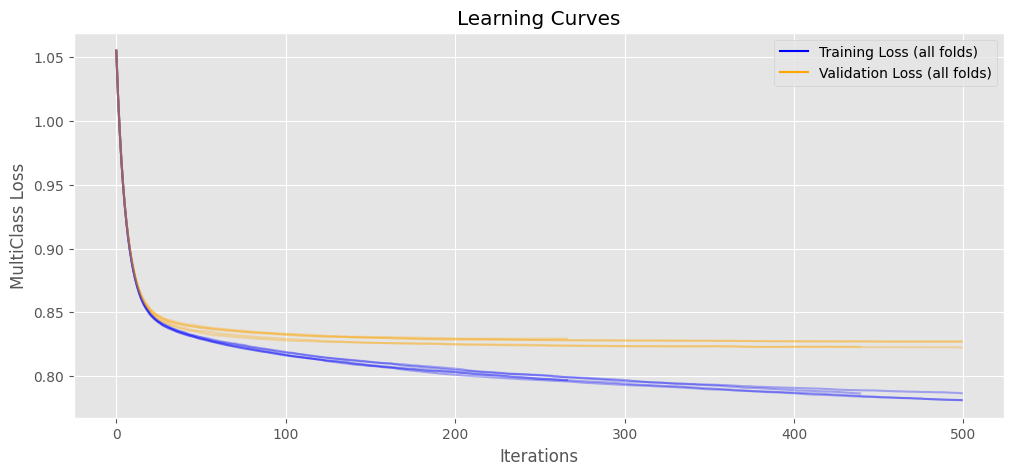

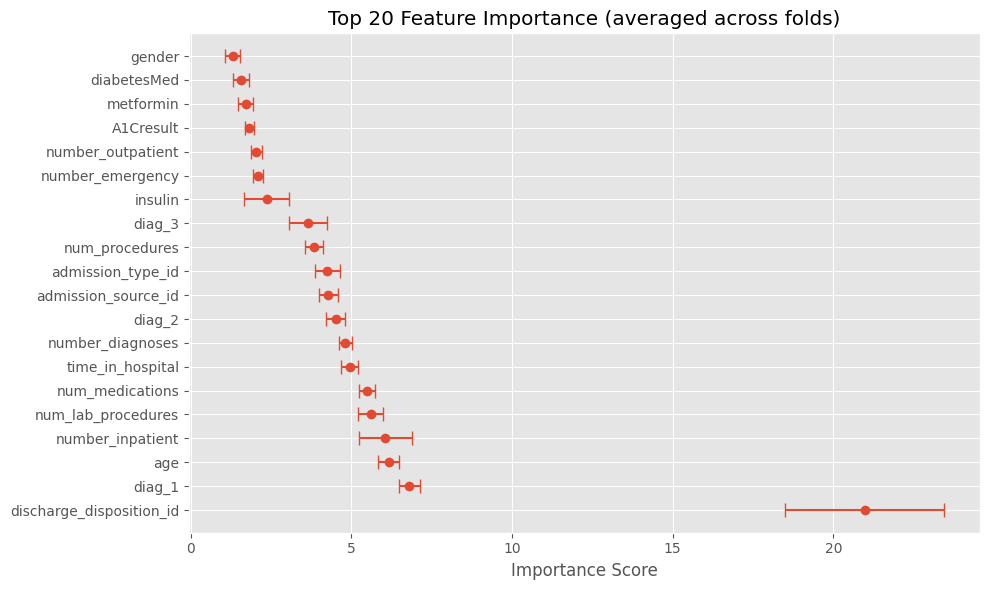

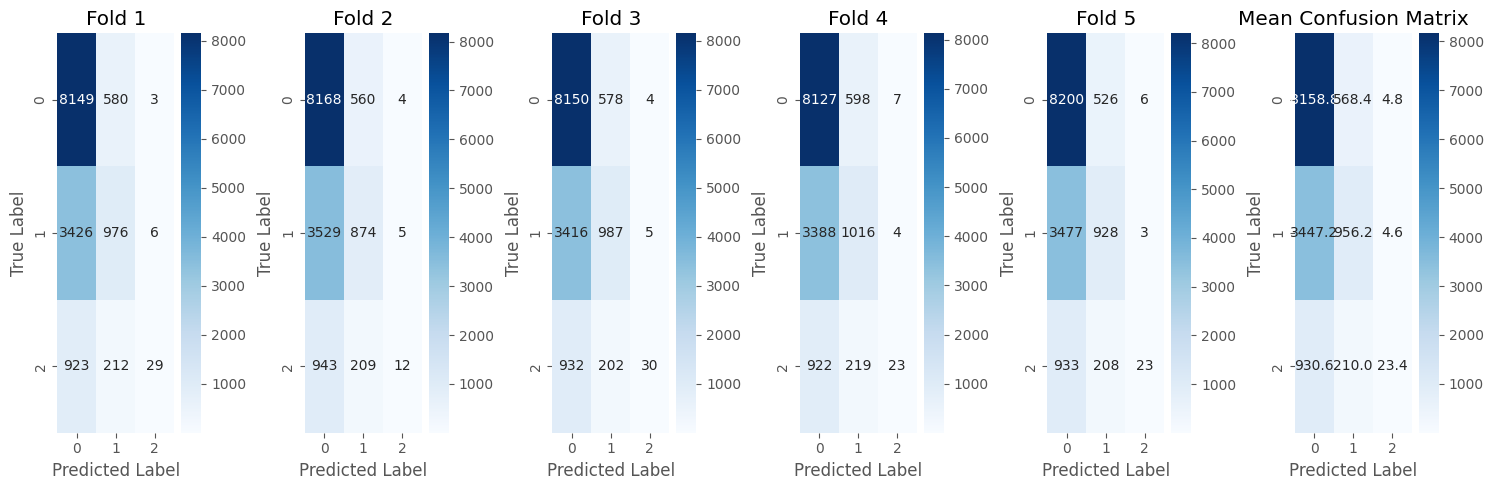

In [21]:
# Initialize the evaluator with your trained models
evaluator = MultiClassCVEvaluator(
    models=trained_models,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cat_features=cat_features
)

# Run all evaluations
evaluator.evaluate_all()
